In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image

%matplotlib inline

In [37]:
train_dir = 'train/train/'
test_dir = 'test1/'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [38]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

In [39]:
dataloader = DataLoader(catdogs, batch_size = 32, shuffle=True, num_workers=0)

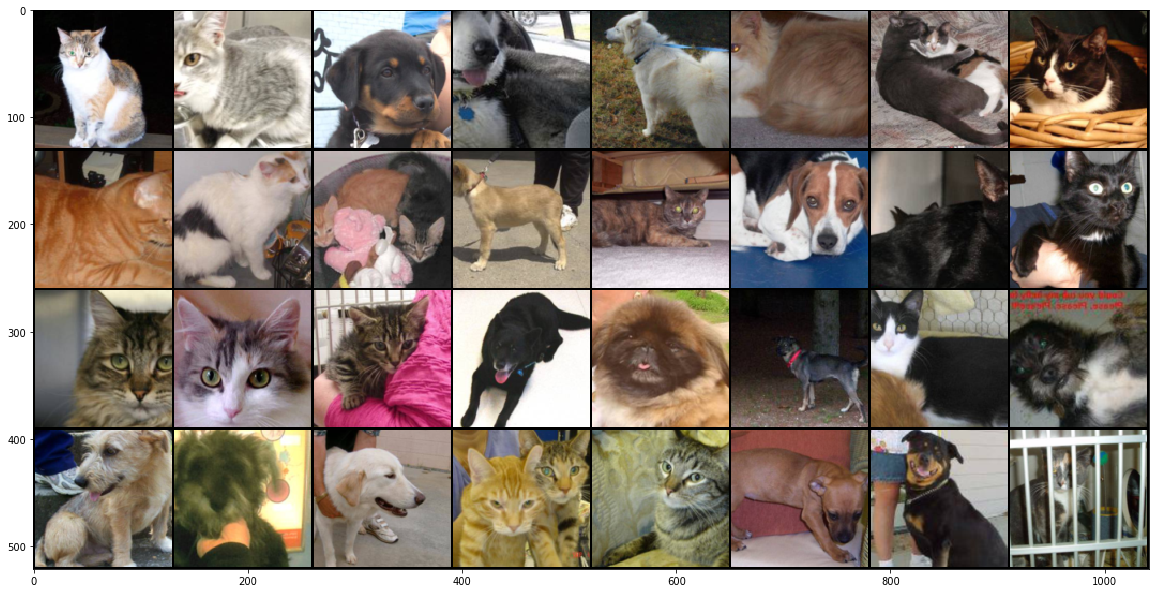

In [40]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(20,20))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [41]:
# transfer learning

device = 'cuda'
model = torchvision.models.densenet121(pretrained=True)

In [42]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

[Epoch 1/3] Iteration 200 -> Train Loss: 0.5293, Accuracy: 0.625
[Epoch 1/3] Iteration 400 -> Train Loss: 0.3342, Accuracy: 0.844
[Epoch 1/3] Iteration 600 -> Train Loss: 0.2682, Accuracy: 0.906
[Epoch 2/3] Iteration 800 -> Train Loss: 0.2005, Accuracy: 0.938
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.1839, Accuracy: 0.906
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.1505, Accuracy: 0.938
[Epoch 2/3] Iteration 1400 -> Train Loss: 0.1445, Accuracy: 0.906
[Epoch 3/3] Iteration 1600 -> Train Loss: 0.1287, Accuracy: 0.969
[Epoch 3/3] Iteration 1800 -> Train Loss: 0.1093, Accuracy: 0.938
[Epoch 3/3] Iteration 2000 -> Train Loss: 0.1170, Accuracy: 1.000
[Epoch 3/3] Iteration 2200 -> Train Loss: 0.1141, Accuracy: 0.969


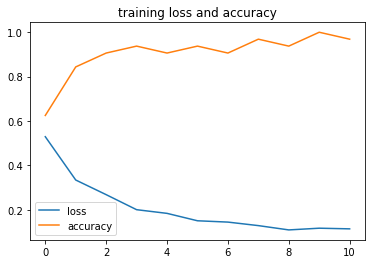

In [43]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [35]:
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False, num_workers=4)